In [1]:
import os
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from keras.models import Sequential
from keras.layers.core import Activation, Dropout, Dense
from keras.layers import Flatten, LSTM

In [2]:
cwd = os.getcwd()
output_dir = os.path.join(cwd, "../../data")
df = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysis.csv"))
df_test = pd.read_csv(os.path.join(output_dir, "combined_sentimentanalysistest.csv"))
#df_test = pd.read_csv(os.path.join(output_dir, "figlet1599056546.006096_1599063766.431225.csv"))
df = df.drop(df[df.responsetime > 10].index)
df.pop('Time')
df_test = df_test.drop(df_test[df_test.responsetime > 10].index)
df_test.pop('Time')
df.head()

,cpu,diskio,diskioRead,diskioWritten,mem,networkReceived,networkTransmitted,replica,requests,responsetime,totalcpu,totalcpuUtilization,totalmemory,totalmemoryUtilization
0,7.452470,0.000129,0.000000,1.484572e+04,0.006211,7.686411e+02,690.618472,1.0,7.0,0.427801,12.0,76.330988,5.045532e+10,10.168922
1,6.314931,0.056578,903.680000,7.635895e+06,0.006211,4.423151e+06,44196.825694,1.0,42.0,0.441701,12.0,76.330988,5.045532e+10,10.168922
2,9.499113,0.073244,1001.244444,9.543407e+06,0.006211,4.011359e+06,41064.000000,1.0,76.0,0.429230,12.0,13.216667,5.045532e+10,10.329697
3,6.085528,0.073156,1001.244444,9.533212e+06,0.026095,4.012145e+06,42053.311111,1.0,112.0,0.421655,12.0,13.216667,5.045532e+10,10.329697
4,9.452724,0.021956,182.044444,2.628813e+06,0.119376,3.909378e+03,3469.288889,1.0,140.0,0.439443,12.0,14.213889,5.045532e+10,10.159327


In [3]:
# remove 2xlarge
df = df.drop(df[df.totalcpu > 16].index)

In [4]:
df_t = pd.DataFrame()
df_ttest = pd.DataFrame()

In [5]:
df_t['total_cpu_util'] = (df['totalcpuUtilization']*(df['totalcpu']*0.67))/100                    
df_t['total_mem_util'] = (df['totalmemoryUtilization']*df['totalmemory'])*1e-9
df_t['responsetime'] = df['responsetime']
df_t['requests'] = df['requests']
#df_t['replica'] = df['replica']
df_ttest['total_cpu_util'] = (df_test['totalcpuUtilization']*(df_test['totalcpu']*0.67))/100
df_ttest['total_mem_util'] = (df_test['totalmemoryUtilization']*df_test['totalmemory'])*1e-9
df_ttest['responsetime'] = df_test['responsetime']
df_ttest['requests'] = df_test['requests']
#df_ttest['replica'] = df_test['replica']
df_t.head()

,total_cpu_util,total_mem_util,responsetime,requests
0,6.137011,513.076211,0.427801,7.0
1,6.137011,513.076211,0.441701,42.0
2,1.062620,521.188136,0.429230,76.0
3,1.062620,521.188136,0.421655,112.0
4,1.142797,512.592066,0.439443,140.0


In [6]:
training_set = df_t.iloc[:, 0:3].values
training_set_y = df_t.iloc[:, 3:4].values
testing_set = df_ttest.iloc[:, 0:3].values
testing_set_y = df_ttest.iloc[:, 3:4].values

In [7]:
training_set

array([[6.13701147e+00, 5.13076211e+02, 4.27800638e-01],
       [6.13701147e+00, 5.13076211e+02, 4.41700992e-01],
       [1.06262000e+00, 5.21188136e+02, 4.29229751e-01],
       ...,
       [2.26259000e+00, 5.72326502e+02, 8.04163451e+00],
       [2.27375667e+00, 5.83109222e+02, 7.74168699e+00],
       [2.27375667e+00, 5.83109222e+02, 6.55949173e+00]])

In [8]:
training_set_y

array([[  7.],
       [ 42.],
       [ 76.],
       ...,
       [188.],
       [240.],
       [292.]])

In [9]:
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)
testing_set_scaled = sc.fit_transform(testing_set)

In [10]:
training_set_scaled.shape

(1543, 3)

In [11]:
testing_set_scaled.shape

(457, 3)

In [12]:
training_set_scaled = np.array(training_set_scaled).reshape(training_set_scaled.shape[0], 1, training_set_scaled.shape[1])
testing_set_scaled = np.array(testing_set_scaled).reshape(testing_set_scaled.shape[0], 1, testing_set_scaled.shape[1])

In [13]:
training_set_scaled.shape

(1543, 1, 3)

In [14]:
model = Sequential()
model.add(LSTM(200, activation='relu', return_sequences=True,input_shape=(1, 3)))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(LSTM(50, activation='relu', return_sequences=True))
model.add(LSTM(25, activation='relu'))
model.add(Dense(20, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 1, 200)            163200    
_________________________________________________________________
lstm_1 (LSTM)                (None, 1, 100)            120400    
_________________________________________________________________
lstm_2 (LSTM)                (None, 1, 50)             30200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 25)                7600      
_________________________________________________________________
dense (Dense)                (None, 20)                520       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [15]:
history = model.fit(training_set_scaled, training_set_y, epochs=5000, validation_split=0.2, batch_size=50, verbose=0)

In [16]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10000])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

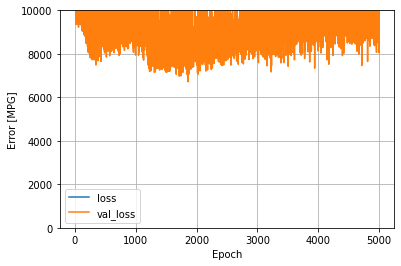

In [17]:
plot_loss(history)

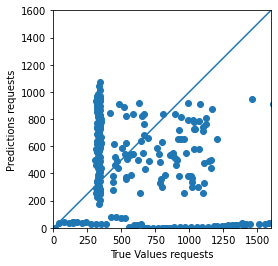

In [18]:
test_predictions = model.predict(testing_set_scaled).flatten()

a = plt.axes(aspect='equal')
plt.scatter(testing_set_y, test_predictions)
plt.xlabel('True Values requests')
plt.ylabel('Predictions requests')
lims = [0, 1600]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

In [19]:
from sklearn.metrics import r2_score
R = r2_score(testing_set_y, test_predictions)
print ('R² :',R)

R² : 0.024401485026157133
